<a href="https://colab.research.google.com/github/sjkim-audio/Bass-separator/blob/main/notebooks/transcription/Melody_Extraction_%26_Pitch_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 공유 드라이브에 있는 오디오 파일 다운로드

import gdown
import librosa
from IPython.display import Audio

# 1. 구글 드라이브 공유 링크에서 'FILE_ID' 부분만 추출
# 예: https://drive.google.com/file/d/1A2B3C.../view -> '1A2B3C...'
file_id = '1bjwVU8lThj2E1TDs1rwhZwZTcUgTOASc'

# 2. 다운로드할 URL 구성
url = f'https://drive.google.com/uc?id={file_id}'

# 3. 파일 저장 경로 및 이름 설정
output_filename = 'downloaded_audio.wav'

# 4. 파일 다운로드
gdown.download(url, output_filename, quiet=False)

# 5. 다운로드한 파일 로드 (48kHz 설정)
# y: 오디오 데이터, sr: 샘플링 레이트 (해당 음원은 48kHz로 렌더링됨)
try:
    y, sr = librosa.load(output_filename, sr=None)
    print(f"샘플링 레이트 {sr}Hz")
    print(f"오디오 길이: {len(y) / sr:.2f}초")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")

Audio(data=y, rate=sr)

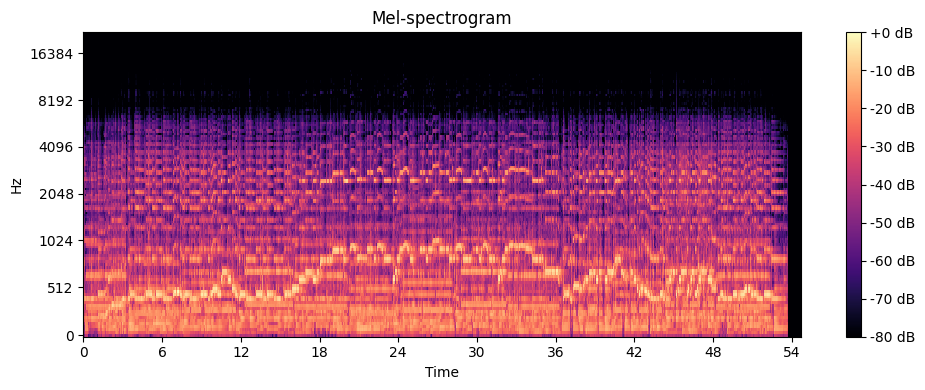

In [8]:
# 다운받은 오디오 데이터 멜스펙트로그램 시각화
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# 1. 멜 스펙트로그램 계산
# n_mels: 멜 필터의 개수 (보통 128개 사용)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# 2. 데시벨(dB) 스케일로 변환
# 스펙트로그램의 진폭을 로그 스케일(dB)로 변환하여 시각화 효과를 높입니다.
S_dB = librosa.power_to_db(S, ref=np.max)

# 3. 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()


스펙트로그램 상에서 진하게 표시된 라인 발견
-> 퍼스트 기타 솔로 라인으로 추정
-> 음 추출 시도

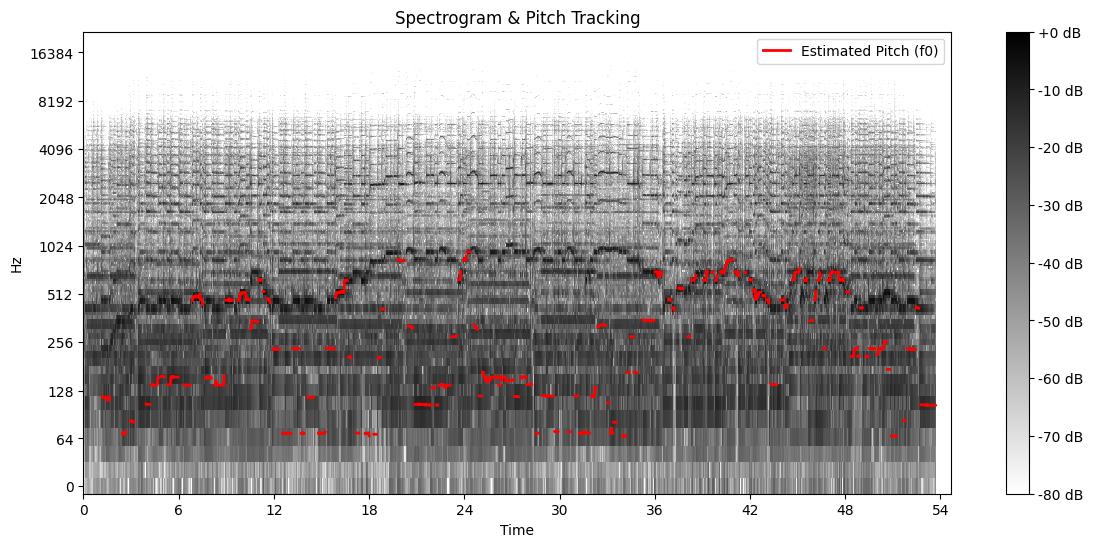


🎵 Detected Notes (Sampled):
Time: 1.20s | Pitch: 117.2 Hz | Note: A♯2
Time: 1.43s | Pitch: 115.9 Hz | Note: A♯2
Time: 2.46s | Pitch: 68.9 Hz | Note: C♯2
Time: 3.01s | Pitch: 82.9 Hz | Note: E2
Time: 4.01s | Pitch: 105.0 Hz | Note: G♯2
Time: 4.32s | Pitch: 139.4 Hz | Note: C♯3
Time: 4.55s | Pitch: 138.6 Hz | Note: C♯3
Time: 4.95s | Pitch: 157.4 Hz | Note: D♯3
Time: 5.36s | Pitch: 139.4 Hz | Note: C♯3
Time: 5.60s | Pitch: 156.5 Hz | Note: D♯3
Time: 5.83s | Pitch: 155.6 Hz | Note: D♯3
Time: 6.41s | Pitch: 138.6 Hz | Note: C♯3
Time: 6.64s | Pitch: 138.6 Hz | Note: C♯3
Time: 6.99s | Pitch: 491.0 Hz | Note: B4
Time: 7.22s | Pitch: 491.0 Hz | Note: B4
Time: 7.45s | Pitch: 474.3 Hz | Note: A♯4
Time: 7.87s | Pitch: 155.6 Hz | Note: D♯3
Time: 8.31s | Pitch: 138.6 Hz | Note: C♯3
Time: 8.72s | Pitch: 138.6 Hz | Note: C♯3
Time: 9.04s | Pitch: 468.9 Hz | Note: A♯4
Time: 9.29s | Pitch: 468.9 Hz | Note: A♯4
Time: 9.85s | Pitch: 491.0 Hz | Note: B4
Time: 10.08s | Pitch: 520.2 Hz | Note: C5
Time: 10.31

In [10]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 1. 오디오 파일 로드
y, sr = librosa.load( output_filename, sr=44100)

# 2. 피치 트래킹 (PYIN 알고리즘)
# f0: 추정된 주파수 (Hz), voiced_flag: 소리가 있는 구간인지 여부
# fmin, fmax: 분석할 음역대 설정 (기타/베이스에 맞춰 조절 가능)
f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'),
                                             sr=sr)

# 3. 결과 시각화 (스펙트로그램 위에 피치 덮어쓰기)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
times = librosa.times_like(f0, sr=sr)

plt.figure(figsize=(14, 6))

# 배경: 스펙트로그램
librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr, cmap='gray_r')

# 전경: 추출한 피치 (빨간 선)
plt.plot(times, f0, label='Estimated Pitch (f0)', color='red', linewidth=2)

plt.title('Spectrogram & Pitch Tracking')
plt.legend(loc='upper right')
plt.colorbar(format='%+2.0f dB')
plt.show()

# 4. 주파수(Hz)를 계이름(Note)으로 변환
# 소리가 있는 구간(voiced)에서만 추출
valid_f0 = f0[voiced_flag]
valid_times = times[voiced_flag]

# 0.5초 간격으로 어떤 음인지 출력해보기
print("\n🎵 Detected Notes (Sampled):")
for i in range(0, len(valid_f0), 20): # 너무 많으니 띄엄띄엄 출력
    hz = valid_f0[i]
    time = valid_times[i]
    note = librosa.hz_to_note(hz)
    print(f"Time: {time:.2f}s | Pitch: {hz:.1f} Hz | Note: {note}")